In [ ]:
## Has to be run as root
## $ docker exec -it -u root suspicious_hermann /bin/bash
## # apt-get update
## # apt-get install graphviz

## Installing this results in an error, but if not installed there's a warning.  Don't care, not going to fix
# !pip install pulp
#!pip install pm4py

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import datetime
import random

import pm4py

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


In [ ]:
## I need some fake data, so first we'll generate a dataset of Sensor_Data -> Data_Transfer -> <Empty Space where humans do manual work on untracked system> -> Data_Submit -> Data_Transfer2
##    These data points will be stored in a tabular format. With timestamps for each of the steps.  The Empty step might cause the message to not go farther.  Id's can be duplicated.

id_col_name, sns_col_name, tnf_col_name, sbt_col_name, tnf2_col_name, msg_col_name = \
    "id", "sensed_timestamp", "transfer_timestamp", "submitted_timestamp", "transfer2_timestamp", \
    "message"

## So that our timestamp all occur in the past, we will create a minimum offset
tmstp_min = datetime.timedelta(0, -3600 * 24 * 2)
tmstp_rng = 3000
tmtnf_off, tmtnf_rng   = 1, 10
tmsbt_off, tmsbt_rng   = 60, 1800
tmtnf2_off, tmtnf2_rng = 15, 60

## Probability of the Submit/Transfer2 timestamps
sbt_probability = .75

df = {
    id_col_name: [],
    sns_col_name: [],
    tnf_col_name: [],
    sbt_col_name: [],
    tnf2_col_name: [],
    msg_col_name: []
}

for i in range(500):
    ## Create a timestamp, using the current timestamp
    tmstp = []
    tmstp.append(datetime.datetime.now() + tmstp_min + datetime.timedelta(0, random.randrange(tmstp_rng)))
    tmstp.append(tmstp[0] + datetime.timedelta(0, random.randrange(tmtnf_off, tmtnf_off + tmtnf_rng)))

    if random.random() <= sbt_probability:
        tmstp.append(tmstp[1] + datetime.timedelta(0, random.randrange(tmsbt_off, tmsbt_off + tmsbt_rng)))
        tmstp.append(tmstp[2] + datetime.timedelta(0, random.randrange(tmtnf2_off, tmtnf2_off + tmtnf2_rng)))
    else:
        tmstp.append(None)
        tmstp.append(None)

    df[id_col_name].append(f"idx_{i}")
    df[sns_col_name].append(tmstp[0])
    df[tnf_col_name].append(tmstp[1])
    df[sbt_col_name].append(tmstp[2])
    df[tnf2_col_name].append(tmstp[3])
    df[msg_col_name].append(f"Message regarding entity [entity_id00{i}] tracked by ...") ## TO-DO: Randomize me

## Convert the df to an actual DataFrame
df_sys1 = pd.DataFrame(df)
df_sys1.head()

,id,sensed_timestamp,transfer_timestamp,submitted_timestamp,transfer2_timestamp,message
0,idx_0,2024-10-14 18:09:40.212160,2024-10-14 18:09:46.212160,NaT,NaT,Message regarding entity [entity_id000] tracke...
1,idx_1,2024-10-14 18:29:21.212189,2024-10-14 18:29:29.212189,NaT,NaT,Message regarding entity [entity_id001] tracke...
2,idx_2,2024-10-14 18:19:41.212196,2024-10-14 18:19:45.212196,NaT,NaT,Message regarding entity [entity_id002] tracke...
3,idx_3,2024-10-14 18:27:01.212201,2024-10-14 18:27:04.212201,2024-10-14 18:48:04.212201,2024-10-14 18:48:57.212201,Message regarding entity [entity_id003] tracke...
4,idx_4,2024-10-14 17:40:12.212209,2024-10-14 17:40:20.212209,2024-10-14 17:59:06.212209,2024-10-14 17:59:21.212209,Message regarding entity [entity_id004] tracke...


In [ ]:
## LIST STEPS, Ingest will alwasys be the first step.  IF NONE or CLOSED, then there is no next step
STEPS = ["INGEST", "PROCESSING", "ASSIGNED", "WORKING", "PENDING_APPROVAL", "APPROVED", "CLOSED", "NONE"]

NEXT, TMIN, TRNG, PROB = "NEXT_STEPS", "TIME_MIN", "TIME_RANGE", "PROBABILITY"

## Build a map of all the STEPS, the next steps possible, time between steps
STEP_MAP = {
    STEPS[0]: {
        NEXT: [STEPS[1], STEPS[7]],
        TMIN: [1,   -1],
        TRNG: [120, -1],
        PROB: [.3,   1],
    },
    STEPS[1]: {
        NEXT: [STEPS[0], STEPS[1], STEPS[2], STEPS[3], STEPS[7]],
        TMIN: [1,        120,      200,      360,      -1],
        TRNG: [1200,     180,      360,      360,      -1],
        PROB: [.1,       .2,       .5,       .8,        1],
    },
    STEPS[2]: {
        NEXT: [STEPS[0], STEPS[1], STEPS[2], STEPS[3], STEPS[7]],
        TMIN: [120,      200,      200,      120,      -1],
        TRNG: [1200,     300,      360,      620,      -1],
        PROB: [.03,      .06,      .09,      .6,        1],
    },
    STEPS[3]: {
        NEXT: [STEPS[0], STEPS[3], STEPS[4], STEPS[5], STEPS[7]],
        TMIN: [120,      300,      600,      1200,     -1],
        TRNG: [1200,     300,      600,      6200,     -1],
        PROB: [.03,      .06,      .9,      .95,        1],
    },
    STEPS[4]: {
        NEXT: [STEPS[0], STEPS[4], STEPS[5], STEPS[6], STEPS[7]],
        TMIN: [120,      120,      480,      1200,     -1],
        TRNG: [1200,     300,      900,      6200,     -1],
        PROB: [.03,      .06,      .9,      .91,        1],
    },
    STEPS[5]: {
        NEXT: [STEPS[0], STEPS[1], STEPS[5], STEPS[6], STEPS[7]],
        TMIN: [120,      120,      30,       1200,     -1],
        TRNG: [1200,     300,      900,      6200,     -1],
        PROB: [.03,      .12,      .15,      .93,        1],
    },
    STEPS[6]: { NEXT: [], TMIN: [], TRNG: [], PROB: [], },
    STEPS[7]: { NEXT: [], TMIN: [], TRNG: [], PROB: [], },
}

In [ ]:
## Take the steps below and generate some random data
id_col, step_col, tmp_col = "id_col", "step_col", "tmp_col"
df2 = {
    id_col: [], step_col: [], tmp_col: [],
}

## Loop through all the entries in the df,
for i in range(len(df[id_col_name])): #range(5): #
    idx = df[id_col_name][i]
    tmpstp = df[tnf2_col_name][i]

    ## if there was a transfer2 timestamp
    if tmpstp is not None:
        nxt_step = STEPS[0]
        nxt_tmStp = tmpstp + datetime.timedelta(0, random.randrange(15)) ## Increment our timestamp

        ## While our next_step doesn't equal Close or None
        while nxt_step != STEPS[6] and nxt_step != STEPS[7]:
            df2[id_col].append(idx)
            df2[step_col].append(nxt_step)
            df2[tmp_col].append(nxt_tmStp)

            cur_step = nxt_step
            rnd_vle = random.random()

            for j in range(len(STEP_MAP[nxt_step][PROB])):
                if rnd_vle <= STEP_MAP[nxt_step][PROB][j]:
                    nxt_step = STEP_MAP[nxt_step][NEXT][j]
                    if nxt_step == STEPS[6] or nxt_step == STEPS[7]:
                        break

                    nxt_tmStp = nxt_tmStp + datetime.timedelta(0, random.randrange(STEP_MAP[nxt_step][TMIN][j], STEP_MAP[nxt_step][TMIN][j] + STEP_MAP[nxt_step][TRNG][j]))
                    break


        if nxt_step == STEPS[6]:
            df2[id_col].append(idx)
            df2[step_col].append(nxt_step)
            df2[tmp_col].append(nxt_tmStp)


df_sys2 = pd.DataFrame(df2)
df_sys2.head()

,id_col,step_col,tmp_col
0,idx_3,INGEST,2024-10-14 18:49:01.212201
1,idx_4,INGEST,2024-10-14 17:59:34.212209
2,idx_7,INGEST,2024-10-14 18:31:56.212227
3,idx_7,PROCESSING,2024-10-14 18:34:39.212227
4,idx_8,INGEST,2024-10-14 18:25:15.212234


In [ ]:
df_sys2["step_col"].unique()

array(['INGEST', 'PROCESSING', 'WORKING', 'PENDING_APPROVAL', 'ASSIGNED',
       'APPROVED', 'CLOSED'], dtype=object)

In [ ]:
pm4_log = pm4py.format_dataframe(df_sys2, case_id="id_col", activity_key="step_col", timestamp_key="tmp_col")
print(f"Start Activities: {pm4py.get_start_activities(pm4_log)}")
print(f"End Activities: {pm4py.get_end_activities(pm4_log)}")

Start Activities: {'INGEST': 343}
End Activities: {'INGEST': 247, 'ASSIGNED': 24, 'PROCESSING': 24, 'CLOSED': 42, 'APPROVED': 2, 'PENDING_APPROVAL': 3, 'WORKING': 1}


# - Stateline
## - Process Model

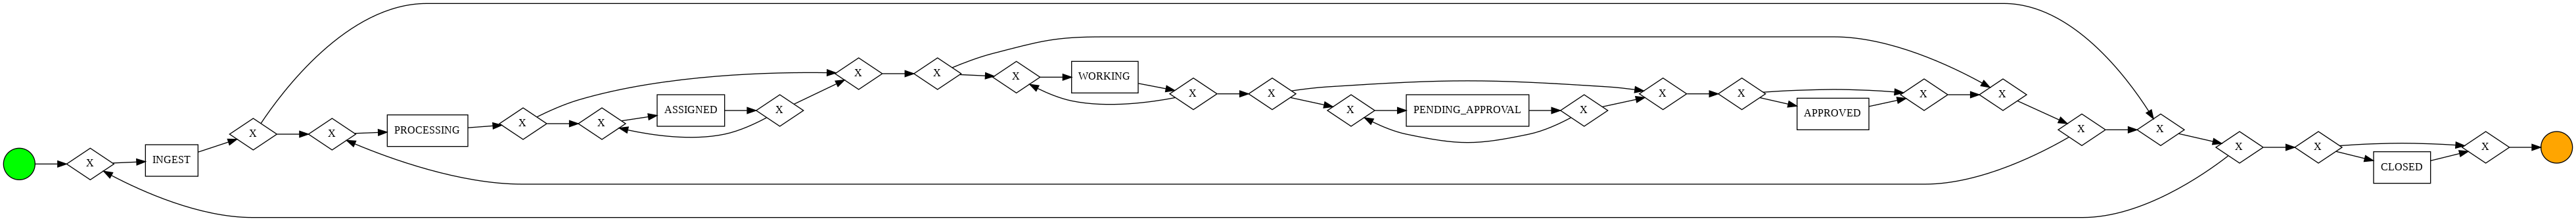

In [ ]:
bpmn_model = pm4py.discover_bpmn_inductive(pm4_log)
pm4py.view_bpmn(bpmn_model)

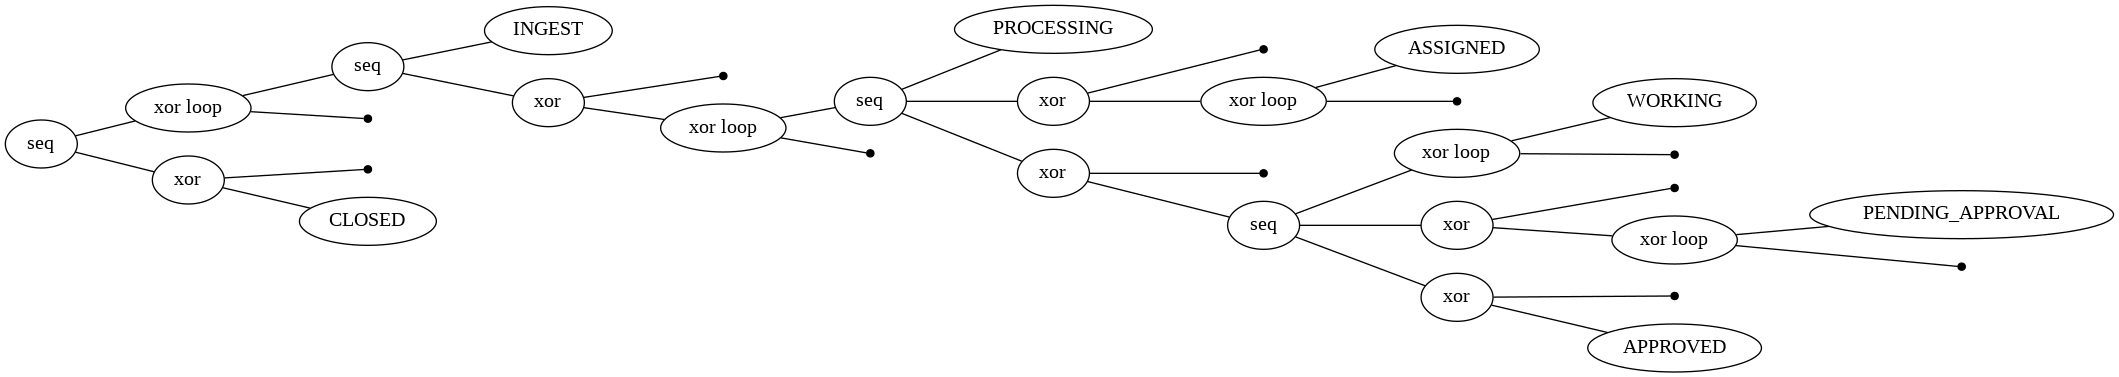

In [ ]:
process_tree = pm4py.discover_process_tree_inductive(pm4_log)
pm4py.view_process_tree(process_tree)

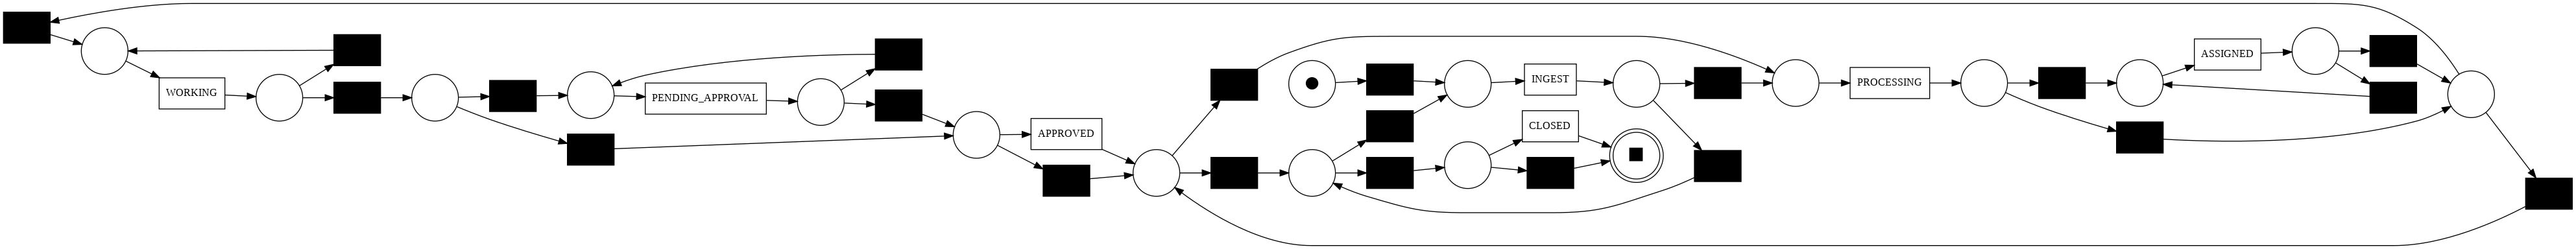

In [ ]:
net1, im1, fm1 = pm4py.convert_to_petri_net(process_tree)
pm4py.view_petri_net(net1,im1,fm1)

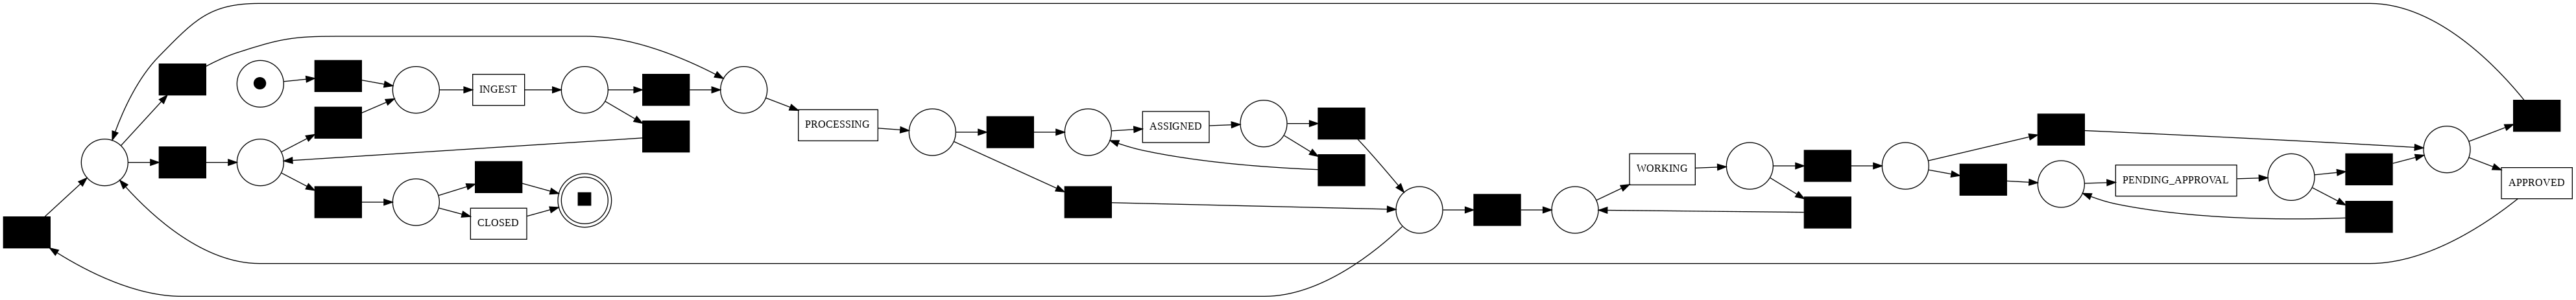

In [ ]:
net2, im2, fm2 = pm4py.discover_petri_net_inductive(pm4_log)
pm4py.view_petri_net(net2, im2, fm2)

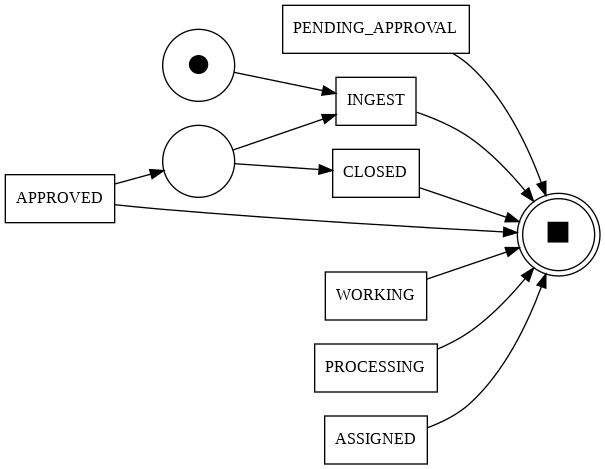

In [ ]:
net3, im3, fm3 = pm4py.discover_petri_net_alpha(pm4_log)
pm4py.view_petri_net(net3, im3, fm3)

<ipython-input-13-18f4cc005d98>:1: DeprecatedWarning: discover_petri_net_alpha_plus is deprecated as of 2.3.0 and will be removed in 3.0.0. this method will be removed in a future release.
  net4, im4, fm4 = pm4py.discover_petri_net_alpha_plus(pm4_log)


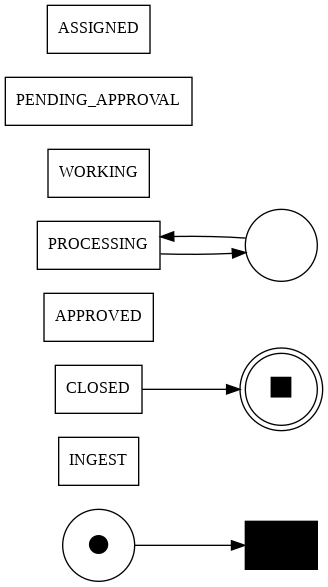

In [ ]:
net4, im4, fm4 = pm4py.discover_petri_net_alpha_plus(pm4_log)
pm4py.view_petri_net(net4, im4, fm4)

## Obtaining a Process Map

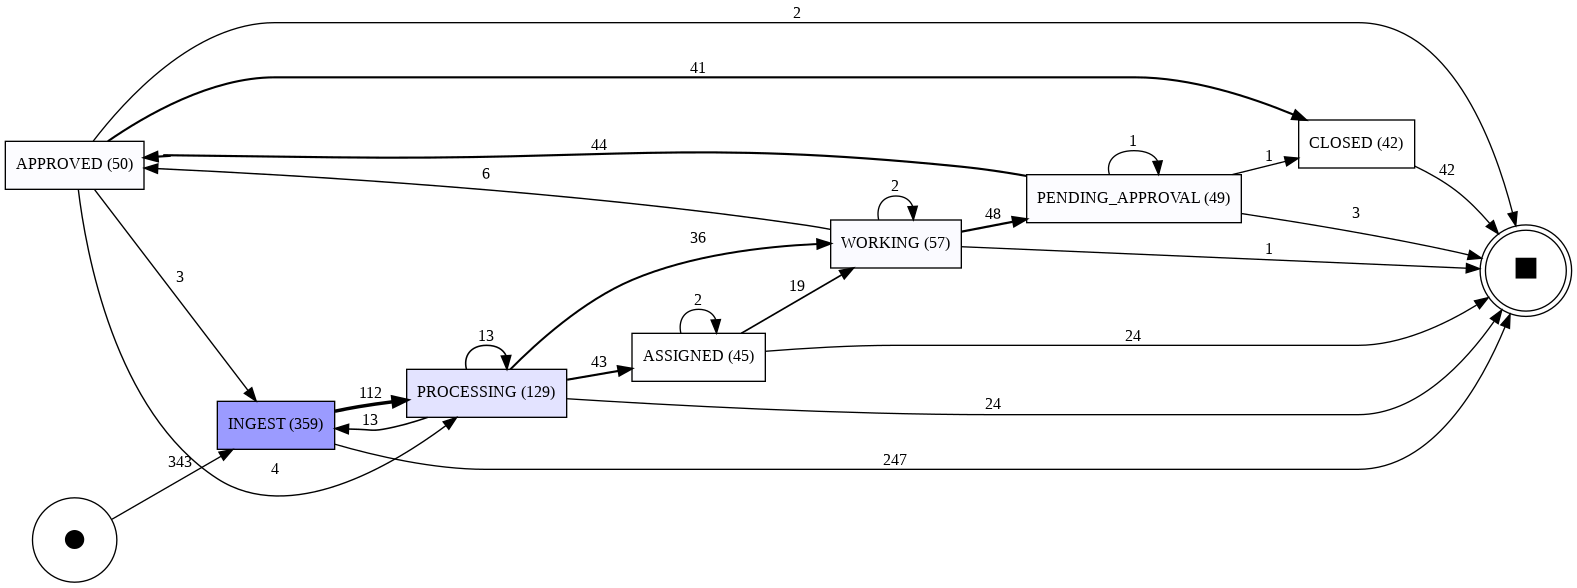

In [ ]:
dfg, start_activities, end_activities = pm4py.discover_dfg(pm4_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

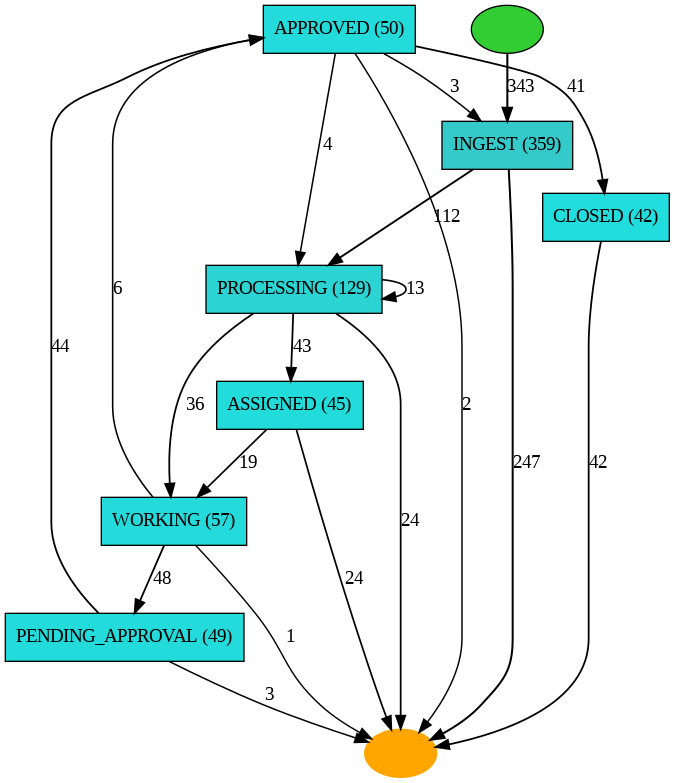

In [ ]:
map = pm4py.discover_heuristics_net(pm4_log)
pm4py.view_heuristics_net(map)

# - Stateline

In [ ]:
import plotly.express as px
df_sys2.head()

,id_col,step_col,tmp_col,case:concept:name,concept:name,time:timestamp
0,idx_3,INGEST,2024-10-14 18:49:01.212201,idx_3,INGEST,2024-10-14 18:49:01.212201
1,idx_4,INGEST,2024-10-14 17:59:34.212209,idx_4,INGEST,2024-10-14 17:59:34.212209
2,idx_7,INGEST,2024-10-14 18:31:56.212227,idx_7,INGEST,2024-10-14 18:31:56.212227
3,idx_7,PROCESSING,2024-10-14 18:34:39.212227,idx_7,PROCESSING,2024-10-14 18:34:39.212227
4,idx_8,INGEST,2024-10-14 18:25:15.212234,idx_8,INGEST,2024-10-14 18:25:15.212234


In [ ]:
unq_wrk_id = df_sys2[df_sys2["step_col"] == "PENDING_APPROVAL"]["id_col"].unique()
work_min = df_sys2[df_sys2.isin({"id_col": unq_wrk_id})["id_col"]]
work_min = work_min.sort_values(["id_col", "tmp_col"])
work_min.head()

,id_col,step_col,tmp_col,case:concept:name,concept:name,time:timestamp
145,idx_114,INGEST,2024-10-14 18:57:59.212973,idx_114,INGEST,2024-10-14 18:57:59.212973
146,idx_114,PROCESSING,2024-10-14 19:08:44.212973,idx_114,PROCESSING,2024-10-14 19:08:44.212973
147,idx_114,WORKING,2024-10-14 20:30:16.212973,idx_114,WORKING,2024-10-14 20:30:16.212973
148,idx_114,PENDING_APPROVAL,2024-10-14 20:50:05.212973,idx_114,PENDING_APPROVAL,2024-10-14 20:50:05.212973
149,idx_114,APPROVED,2024-10-14 20:53:04.212973,idx_114,APPROVED,2024-10-14 20:53:04.212973


In [ ]:
timeline = { "case": [], "step": [], "start": [], "stop": [] }

prev_row = None
for index, row in work_min.iterrows():
    try:
        if prev_row["id_col"] == row["id_col"]:
            timeline["case"].append(row["id_col"])
            timeline["step"].append(prev_row["step_col"])
            timeline["start"].append(prev_row["tmp_col"])
            timeline["stop"].append(row["tmp_col"])

        prev_row = row
    except:
        print(f"Skipping - {row['id_col']}, {row['step_col']} : Probably the first row")
        prev_row = row

timeline = pd.DataFrame(timeline)
timeline = timeline.sort_values(["start"])
timeline.head()

Skipping - idx_114, INGEST : Probably the first row


,case,step,start,stop
139,idx_333,INGEST,2024-10-14 17:57:19.214444,2024-10-14 18:06:57.214444
213,idx_465,INGEST,2024-10-14 17:58:49.215309,2024-10-14 18:03:54.215309
39,idx_149,INGEST,2024-10-14 18:00:12.213215,2024-10-14 18:19:15.213215
111,idx_288,INGEST,2024-10-14 18:01:09.214150,2024-10-14 18:03:36.214150
124,idx_313,INGEST,2024-10-14 18:01:28.214322,2024-10-14 18:06:40.214322


In [ ]:
fig = px.timeline(timeline, x_start="start", x_end="stop", y="case", color="step")
fig.show()

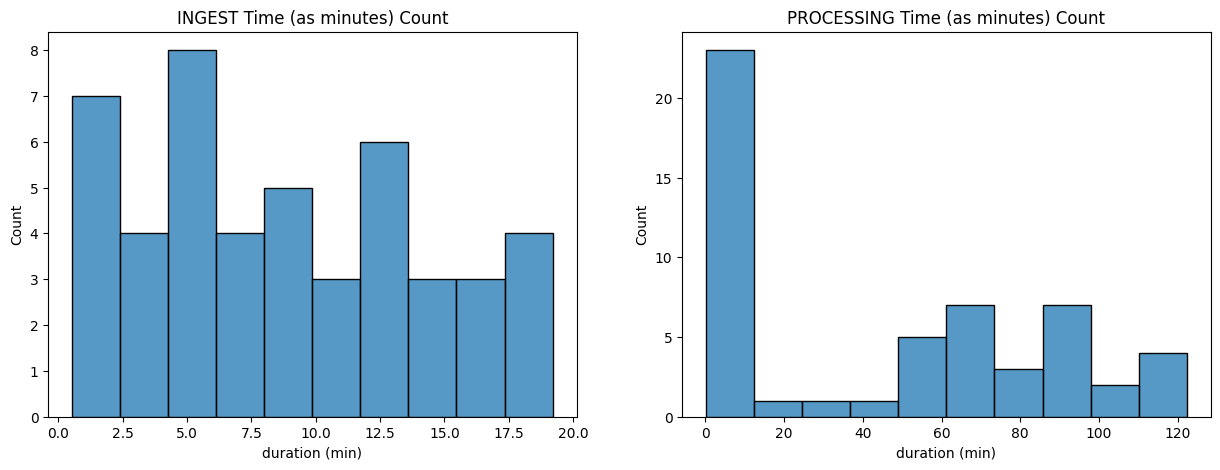

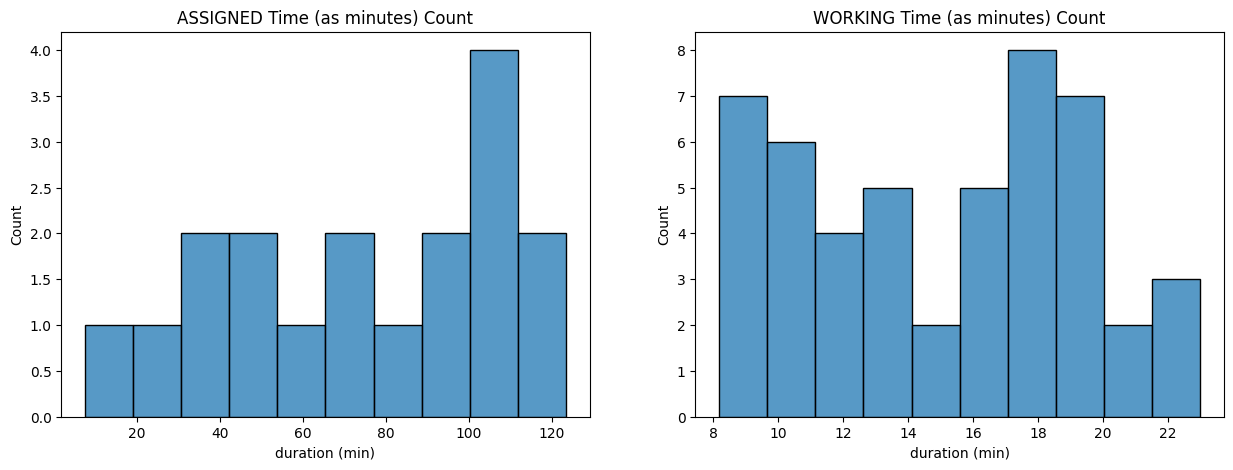

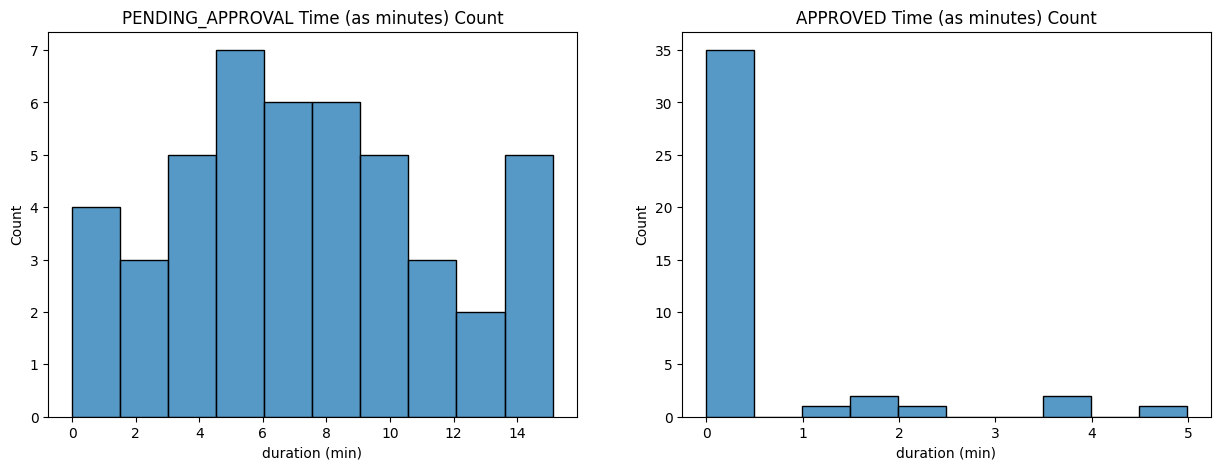

In [ ]:
import seaborn as sns

timeline["duration"] = timeline["stop"] - timeline["start"]
timeline["duration (min)"] = timeline["duration"].dt.total_seconds() / 60

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
i = 0

for s in STEPS[:-2]:
    if i == 2:
        plt.show()
        i = 0
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    s_only = timeline[timeline["step"] == s]
    sns.histplot(data=s_only, x="duration (min)", bins=10, ax=axs[i]).set_title(f"{s} Time (as minutes) Count")
    i += 1

if i != 0:
    plt.show()